In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

from statsmodels.api import OLS

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import f_regression, SelectKBest

import io
import sys
import os

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from fredapi import Fred
import scipy as sc
from tqdm.notebook import tqdm

from statsmodels.tsa.stattools import adfuller

sns.set()

In [2]:
df_tickers = pd.read_excel('data_example.xlsx')

In [3]:
ticker_example = 'NVDA'
data_example = df_tickers[df_tickers.ticker_symbol.isin([ticker_example])].copy()

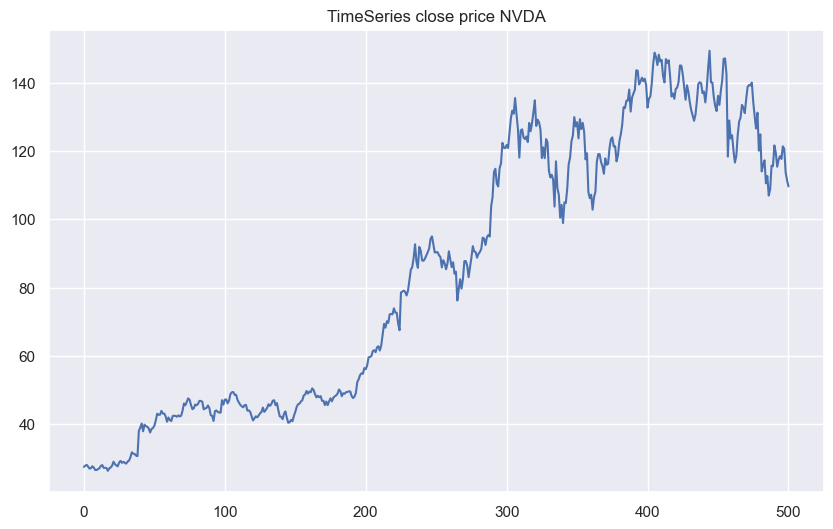

In [4]:
data_example.close.plot(title=f'TimeSeries close price {ticker_example}', figsize=(10,6))
plt.show()

<AxesSubplot:>

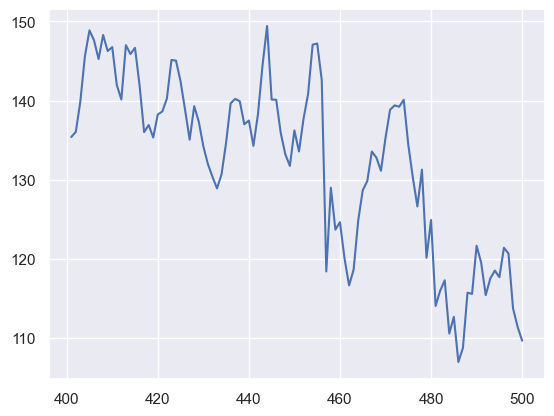

In [5]:
data_example.tail(100)['close'].plot()

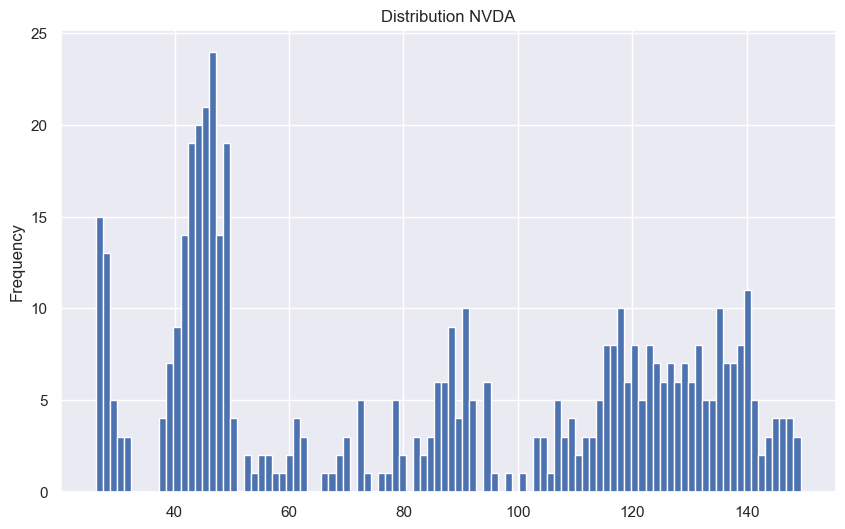

In [6]:
data_example.close.plot(kind='hist', title=f'Distribution {ticker_example}', bins=100, figsize=(10,6))
plt.show()

In [7]:
shift_ = 1
data_shift_example = pd.DataFrame(zip(data_example.close , data_example.close.shift(shift_)), columns=['y', f'yt-{shift_}'])
data_shift_example

,y,yt-1
0,27.383,NaN
1,27.777,27.383
2,27.965,27.777
3,27.453,27.965
4,26.881,27.453
...,...,...
496,121.410,117.700
497,120.690,121.410
498,113.760,120.690
499,111.430,113.760


In [8]:
data_shift_example['y'] - data_shift_example[f'yt-{shift_}']

0        NaN
1      0.394
2      0.188
3     -0.512
4     -0.572
       ...  
496    3.710
497   -0.720
498   -6.930
499   -2.330
500   -1.760
Length: 501, dtype: float64

In [9]:
series_diff = data_shift_example.y.diff()

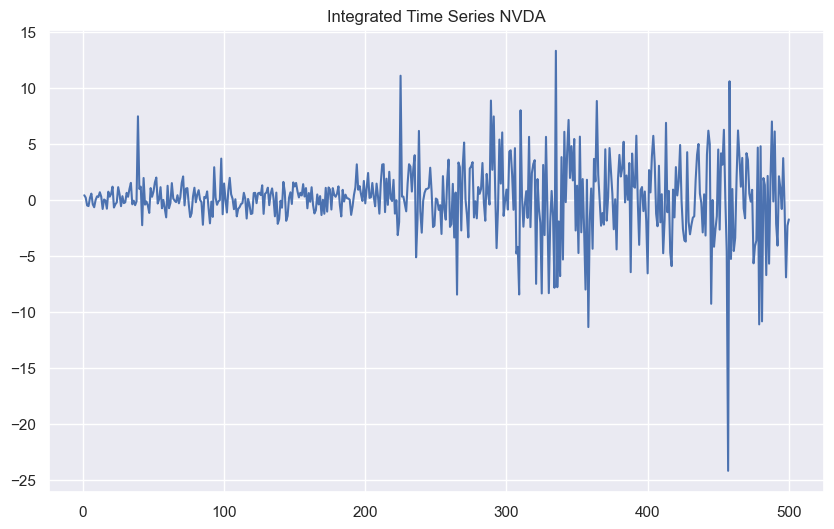

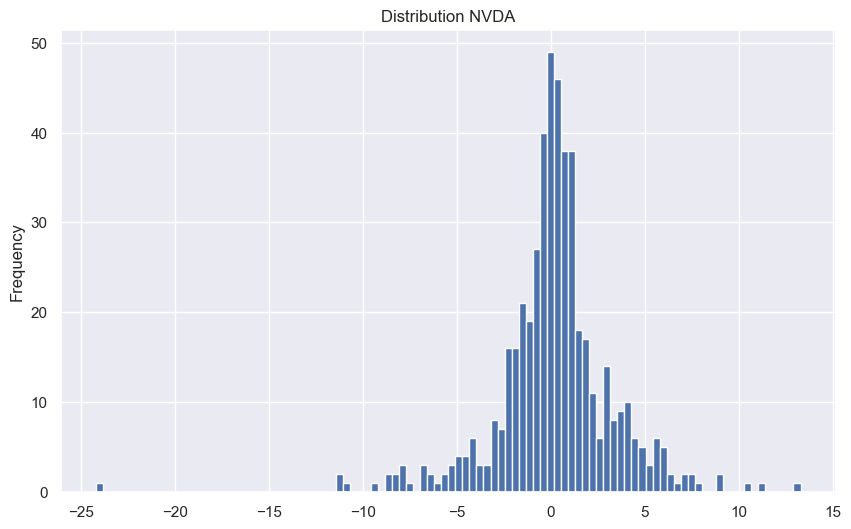

In [10]:
series_diff.plot(title=f'Integrated Time Series {ticker_example}', figsize=(10,6))
plt.show()

series_diff.plot(kind='hist', title=f'Distribution {ticker_example}', bins=100, figsize=(10,6))
plt.show()

In [11]:
series_rates = data_shift_example['y'] / data_shift_example[f'yt-{shift_}'] - 1

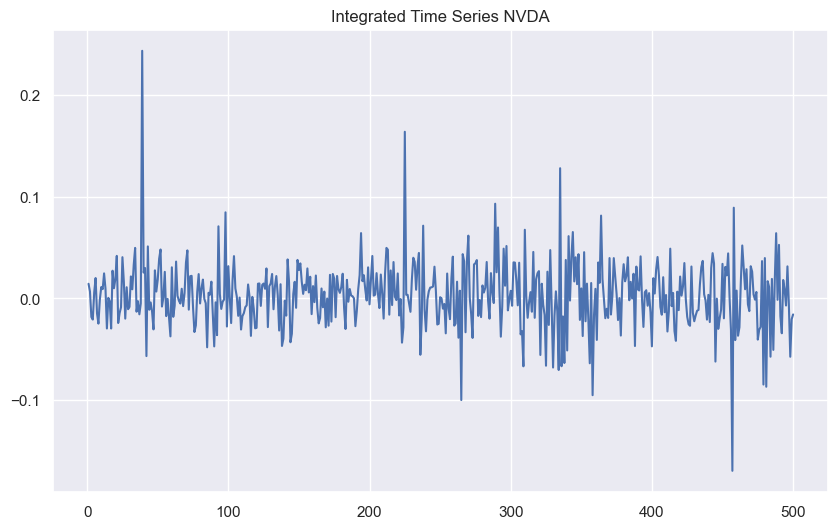

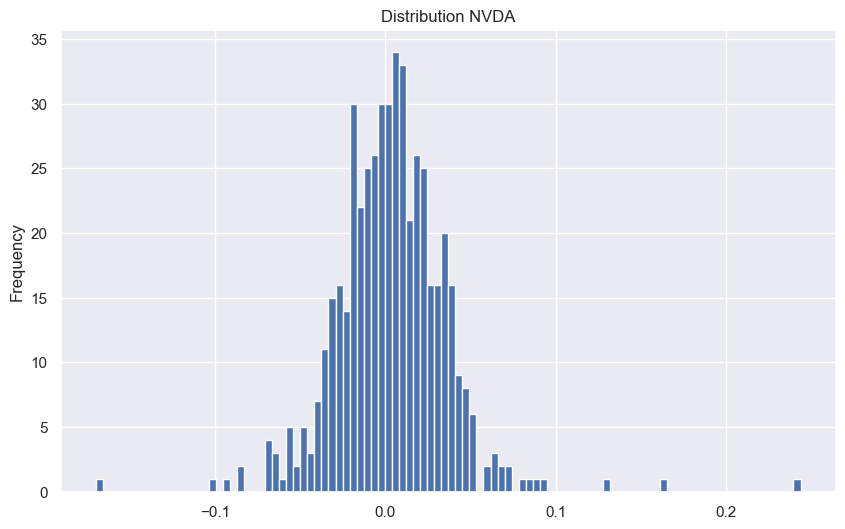

In [12]:
series_rates.plot(title=f'Integrated Time Series {ticker_example}', figsize=(10,6))
plt.show()
series_rates.plot(kind='hist', title=f'Distribution {ticker_example}', bins=100, figsize=(10,6))
plt.show()

In [13]:
def check_normality(series, name="series"):
    """
    Shapiro–Wilk test for normality.
    H0: The data is normally distributed.
    """
    stat, p = sc.stats.shapiro(series.dropna())
    print(f"{name} — Shapiro-Wilk: W={stat:.4f}, p={p:.4f}")
    if p > 0.05:
        print("  → Fail to reject H0: Distribution appears normal\n")
    else:
        print("  → Reject H0: Distribution is NOT normal\n")

def check_stationarity(series, name="series"):
    """
    Augmented Dickey-Fuller test for stationarity.
    H0: The series is non-stationary (unit root present).
    """
    result = adfuller(series.dropna(), autolag='AIC')
    stat, p, lags, nobs, crit = result[0], result[1], result[2], result[3], result[4]
    print(f"{name} — ADF: stat={stat:.4f}, p={p:.4f}")
    for key, val in crit.items():
        print(f"   critical {key}: {val:.4f}")
    if p < 0.05:
        print("  → Reject H0: Series is stationary\n")
    else:
        print("  → Fail to reject H0: Series is NOT stationary\n")
        
def check_jarque_bera(series, name="series"):
    """
    Jarque–Bera test for normality (based on skewness and kurtosis).
    H0: Distribution is normal (skewness = 0, kurtosis = 3).
    """
    jb_stat, jb_p = sc.stats.jarque_bera(series.dropna())
    print(f"{name} — Jarque–Bera: JB={jb_stat:.4f}, p={jb_p:.4f}")
    if jb_p > 0.05:
        print("  → Fail to reject H0: Distribution is close to normal\n")
    else:
        print("  → Reject H0: Distribution is NOT normal\n")

In [14]:
def all_check(series_diff, series_rates):
    check_normality(series_diff, name="Differenced Series")
    check_normality(series_rates, name="Rate-of-Change Series")

    check_stationarity(series_diff, name="Differenced Series")
    check_stationarity(series_rates, name="Rate-of-Change Series")

    check_jarque_bera(series_diff, name="Differenced Series")
    check_jarque_bera(series_rates, name="Rate-of-Change Series")

    

In [15]:
def apply_recursive_difference(series: pd.Series, order: int = 1) -> pd.Series:
    """
    Applies recursive differencing to a time series.
    For example, order=2 will do (yt - yt-1) - (yt-1 - yt-2)
    """
    result = series.copy()
    for _ in range(order):
        result = result.diff()
    return result.dropna()

In [16]:
apply_recursive_difference(data_example.close, order=2)

2     -0.206
3     -0.700
4     -0.060
5      0.728
6      0.386
       ...  
496    4.540
497   -4.430
498   -6.210
499    4.600
500    0.570
Name: close, Length: 499, dtype: float64

In [17]:
def some_example_func(data, shift_=5, plot=False, return_=True):

    data_shift_example = pd.DataFrame(zip(data.close , data.close.shift(shift_)), columns=['y', f'yt-{shift_}'])
    series_diff = apply_recursive_difference(data.close, order = shift_)
    series_rates = data_shift_example['y'] / data_shift_example[f'yt-{shift_}'] - 1
    
    dict_ = {'diff' : series_diff , 
            'rates': series_rates}
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # Верхний ряд: временные ряды
        axes[0, 0].plot(series_rates.index, series_rates.values)
        axes[0, 0].set_title(f'Integrated Series {shift_}')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].grid(True)

        axes[0, 1].plot(series_diff.index, series_diff.values, color='orange')
        axes[0, 1].set_title(f'{shift_} difference')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('ΔPrice')
        axes[0, 1].grid(True)

        # Нижний ряд: гистограммы
        axes[1, 0].hist(series_rates.dropna(), bins=50, alpha=0.7)
        axes[1, 0].set_title(f'Histogram of the integrated time series {shift_}')
        axes[1, 0].set_xlabel('Price')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True)

        axes[1, 1].hist(series_diff.dropna(), bins=50, alpha=0.7, color='orange')
        axes[1, 1].set_title(f'Histogram {shift_} differences')
        axes[1, 1].set_xlabel('ΔPrice')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()
    
    all_check(series_diff , series_rates)
    
    if return_:

        return series_diff , series_rates
    

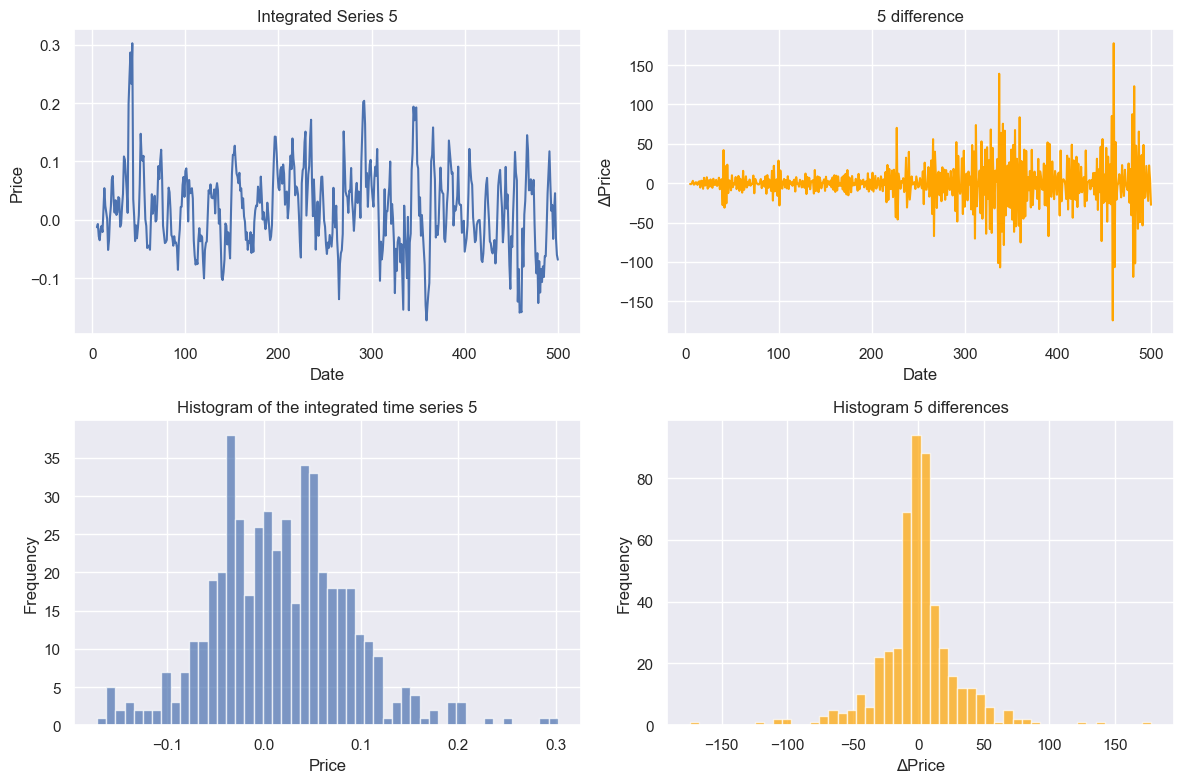

Differenced Series — Shapiro-Wilk: W=0.8954, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Shapiro-Wilk: W=0.9873, p=0.0003
  → Reject H0: Distribution is NOT normal

Differenced Series — ADF: stat=-14.9919, p=0.0000
   critical 1%: -3.4441
   critical 5%: -2.8676
   critical 10%: -2.5700
  → Reject H0: Series is stationary

Rate-of-Change Series — ADF: stat=-4.1291, p=0.0009
   critical 1%: -3.4440
   critical 5%: -2.8676
   critical 10%: -2.5700
  → Reject H0: Series is stationary

Differenced Series — Jarque–Bera: JB=929.9429, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Jarque–Bera: JB=26.7046, p=0.0000
  → Reject H0: Distribution is NOT normal



In [18]:
series_diff , series_rates = some_example_func(data_example, shift_=5, plot=True)

In [19]:
for i in range(1, 25):
    print(i)
    some_example_func(data_example, shift_=i, plot=False, return_=False)
    print(50*'--')
    print('\n')

1
Differenced Series — Shapiro-Wilk: W=0.9075, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Shapiro-Wilk: W=0.9295, p=0.0000
  → Reject H0: Distribution is NOT normal

Differenced Series — ADF: stat=-13.2421, p=0.0000
   critical 1%: -3.4436
   critical 5%: -2.8674
   critical 10%: -2.5699
  → Reject H0: Series is stationary

Rate-of-Change Series — ADF: stat=-23.9976, p=0.0000
   critical 1%: -3.4435
   critical 5%: -2.8673
   critical 10%: -2.5699
  → Reject H0: Series is stationary

Differenced Series — Jarque–Bera: JB=1462.7615, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Jarque–Bera: JB=1382.5732, p=0.0000
  → Reject H0: Distribution is NOT normal

----------------------------------------------------------------------------------------------------


2
Differenced Series — Shapiro-Wilk: W=0.9010, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Shapiro-Wilk: W=0.9617, p=0.0000
  → Reject H0: D

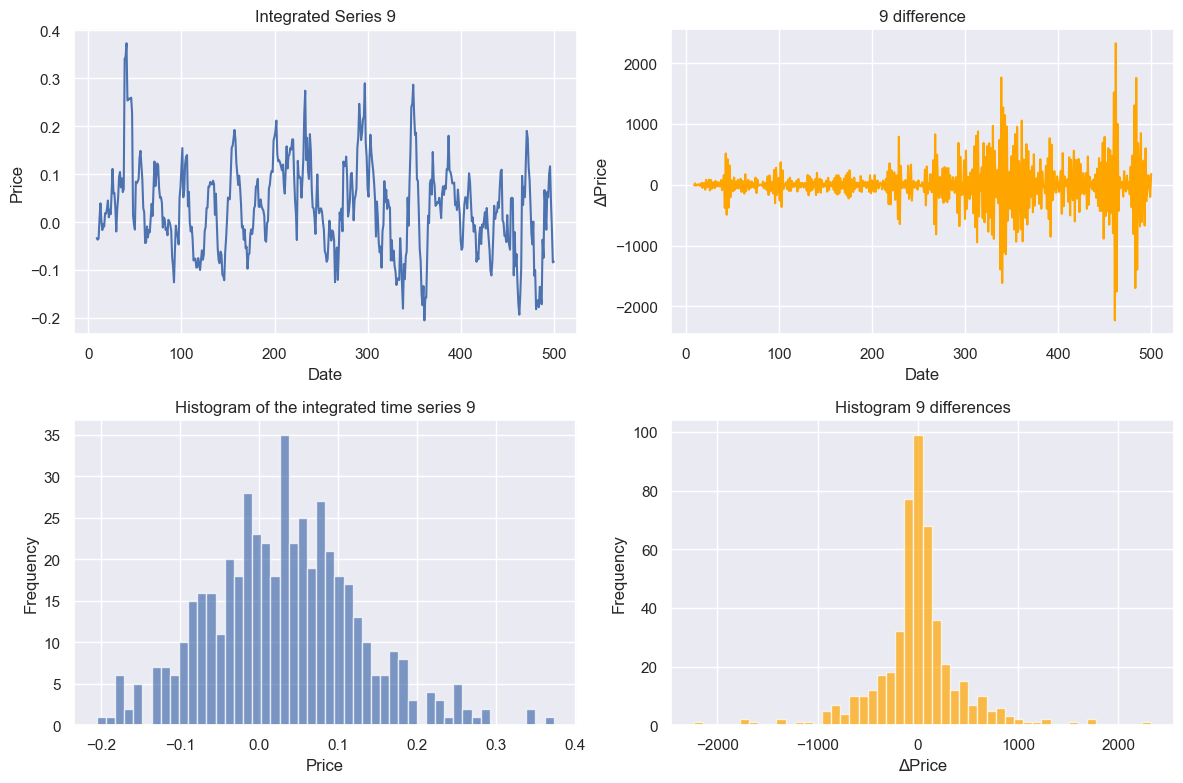

Differenced Series — Shapiro-Wilk: W=0.8973, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Shapiro-Wilk: W=0.9921, p=0.0102
  → Reject H0: Distribution is NOT normal

Differenced Series — ADF: stat=-18.8186, p=0.0000
   critical 1%: -3.4443
   critical 5%: -2.8677
   critical 10%: -2.5700
  → Reject H0: Series is stationary

Rate-of-Change Series — ADF: stat=-3.4066, p=0.0107
   critical 1%: -3.4443
   critical 5%: -2.8677
   critical 10%: -2.5700
  → Reject H0: Series is stationary

Differenced Series — Jarque–Bera: JB=662.8828, p=0.0000
  → Reject H0: Distribution is NOT normal

Rate-of-Change Series — Jarque–Bera: JB=11.2388, p=0.0036
  → Reject H0: Distribution is NOT normal



In [20]:
some_example_func(data_example, shift_=9, plot=True, return_=False)

In [21]:
def iteration_forecast(dataset:pd.DataFrame, n_integrator):
    for code_id in dataset.SecuritiesCode.unique():
        data_code_id = dataset[dataset['SecuritiesCode'] == code_id]
        integrater(data_code_id, n_integrator)
        # here point to expand count of ema with loop if we have a feature selection
        macd_ind(data_code_id) 
        data_code_id.dropna(inplace=True)
        return data_code_id
    
def lags_for_dataset(dataset:pd.DataFrame,list_features):
    new_df = dataset[list_features].copy()
    n=1
    for i in new_df.columns:
        while n < 10:
            new_df.loc[:,i+f'_{n}'] = new_df.loc[:, i].shift(n)
            n+=1
        n=1
    new_df.dropna(inplace=True)
    return new_df

def func_forecast(list_last_feat:list):
    new_list_of_feautes = []
    for i in list_last_feat:
        i = list(i)
        i[-1] = str(int(i[-1])-(1))
        if int(i[-1]) == 0:
            i = i[:-2]
        i="".join(i)
        new_list_of_feautes.append(i)
    return new_list_of_feautes


def best_integretor(dataset:pd.DataFrame):
    dict_normal_test = {}
    for i in range(1, 25):
        a = (dataset['Close']/dataset['Close'].shift(i)).dropna()
        test_normal = sc.stats.normaltest(a)
        dict_normal_test[i] = test_normal[1]
    a = 0
    ind = 0
    for k, v in dict_normal_test.items():
        if v > a:
            a = v
            ind = k
    return ind

def select_features(X_train, y_train):
    fs = SelectKBest(score_func=f_regression, k=20)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs 

In [22]:


def integrater(dataset:pd.DataFrame, shift):
    dataset.loc[:,'Close_int'] = dataset.loc[:,'Close'].shift(shift)
    dataset.dropna(inplace=True)
    dataset.loc[:,'Close_int'] = dataset.loc[:,'Close'] / dataset.loc[:,'Close_int']
    return dataset

def back_integrater(param, val2):
    return param * val2

def macd_ind(dataset: pd.DataFrame, integretor=True) -> pd.DataFrame:
    if integretor:
        dataset.loc[:,'EMA_25'] = dataset.Close_int.ewm(
            span=25, 
            min_periods=25,
            adjust=True
            ).mean() # EMA_First periods (25)
        dataset.loc[:,'EMA_50'] = dataset.Close_int.ewm(
            span=50,
            min_periods=50,
            adjust=True
            ).mean() # EMA_Second periods (50)
    else:
        dataset.loc[:,'EMA_25'] = dataset.Close.ewm(
            span=25,
            min_periods=25,
            adjust=True
            ).mean() # EMA_First periods (25)
        dataset.loc[:,'EMA_50'] = dataset.Close.ewm(
            span=50,
            min_periods=50,
            adjust=True
            ).mean() # EMA_Second periods (50)
    
    dataset.loc[:,'MACD'] = dataset.loc[:,'EMA_25'] - dataset.loc[:,'EMA_50'] # Convergence/Divergence of Exponential Moving Average
    dataset.loc[:,'signal'] = dataset.loc[:,'MACD'].ewm(span=9, min_periods=9, adjust=True).mean()   # signal EMA of MACD
    dataset.loc[:,'histogram'] = dataset.loc[:,'MACD'] - dataset.loc[:,'signal']         #  # Convergence/Divergence of MACD and signal
    dataset.loc[:,'long_trend'] = dataset.loc[:,'histogram'].apply(lambda x: 1 if x >= 0 else 0)
    dataset.loc[:,'short_trend'] = dataset.loc[:,'histogram'].apply(lambda x: 1 if x < 0 else 0)
    return dataset




def forecasting(data:pd.DataFrame, code: str, prediction_periods, n_integration=1):
    """SecuritiesCode"""
    data_code_id = data.copy()
    

    data_code_id = iteration_forecast(data_code_id, n_integration)



    df_to_fitting = lags_for_dataset(data_code_id,['Close_int','EMA_25',
                                                   'EMA_50','MACD',
                                                   'histogram','signal'])
    
    y = df_to_fitting['Close_int'].copy()
    X = df_to_fitting.drop(columns = ['Close_int',
                                      'EMA_25','EMA_50',
                                      'MACD','histogram',
                                      'signal','Close_int_1',
                                      'EMA_25_1','EMA_50_1',
                                      'MACD_1','histogram_1',
                                      'signal_1'])
    
    selection = select_features(X, y)
    list_features = list()
    for k, i in enumerate(selection[1].get_support()):
        if i == True:
            list_features.append(X.columns[k])
    model_code = OLS(y, X[list_features]).fit()
    coeff2 = model_code.rsquared
    print(coeff2)
    if coeff2 <= 0.9:
        print(coeff2)
    df_to_fitting['Prediction'] = model_code.predict()
    data_code_id = data_code_id.join(df_to_fitting['Prediction'])
    data_code_id['fact_pred'] = (data_code_id.Prediction * data_code_id.Close.shift(n_integration))
    data_code_id.dropna(inplace=True)
    data_cov = pd.Series((data_code_id['Close'] - data_code_id.fact_pred)/data_code_id['Close'], index=data_code_id.index)
    dict_prediction = {}
    list_prediction = []
    
    new_list = func_forecast(list_features)
    
    for numb in range(prediction_periods):
        df_for_predict = iteration_forecast(data, n_integration)
        df_for_predict_ = lags_for_dataset(df_for_predict,['Close_int','EMA_25',
                                                       'EMA_50','MACD',
                                                       'histogram','signal'])
        prediction_code=model_code.predict(df_for_predict_.tail(1)[new_list].values)
        prediction_code = prediction_code[0] * df_for_predict.tail(
            n_integration).iloc[[0]]['Close'].values
        list_prediction.append(prediction_code)
        data = pd.concat([data, pd.DataFrame(columns=['SecuritiesCode', 'Close', 'Date'], 
                                             data=[[code, prediction_code[0], data['Date'].max() + pd.DateOffset(1)]])]).reset_index(drop=True)
        
    list_prediction = [x[0] for x in list_prediction]
    dict_prediction.update({code:[list_prediction, 
                                  data_cov, 
                                  data_code_id.set_index('Date')[['Prediction', 
                                                                  'Close_int', 
                                                                  'fact_pred', 
                                                                  'Close']]]})
    return dict_prediction
    
    
def all_code(dataset:pd.DataFrame, prediction_periods=2):
    dict_predict={}
    dataset = dataset.pivot_table(index=['SecuritiesCode','Date'], values='Close').reset_index()
    for k,v in enumerate(dataset.SecuritiesCode.unique()):
        dataset_n = dataset[dataset['SecuritiesCode'] == v].copy()
        n_itegretor = best_integretor(dataset_n)
        dict_prediction = forecasting(dataset_n, v, prediction_periods, n_itegretor)
        dict_predict.update(dict_prediction)
    return dict_predict

In [23]:
def data_modeling(data, tikers:list):
    data_ = {}
    price_hint = {}
    for ticker in tqdm(tikers, desc='Download and forecasting process', dynamic_ncols=True):
        price_hint[ticker] = data
        instrument = data.copy()
        instrument.rename(columns = {'ticker_symbol':'SecuritiesCode',
                                    'open':'Open', 'high' :'High', 'low' :'Low', 'close':'Close'}, inplace=True)
        instrument['SecuritiesCode'] = ticker
        instrument['Date'] = pd.to_datetime(instrument.date)
        last_date = instrument.Close.iloc[[-1]]
        dict_of_prediction = all_code(instrument, prediction_periods=10)
        dict_of_prediction[ticker][2] = pd.merge(dict_of_prediction[ticker][2], instrument[['Open', 'High', 'Low']], left_index=True, right_index=True, how='inner')
        data_[ticker] = dict_of_prediction
        data_[ticker][ticker].append(last_date)
    return data_

In [24]:
data_ = data_modeling(data_example, [ticker_example])

Download and forecasting process:   0%|          | 0/1 [00:00<?, ?it/s]

0.9967464930482475


In [25]:
data_example

,open,high,low,close,volume,vwap,timestamp,transactions,otc,date,ticker_symbol
0,27.229,27.4990,27.1020,27.383,364515740,27.3291,1680148800000,441761,NaN,20230330,NVDA
1,27.140,27.8343,27.1050,27.777,433932770,27.5789,1680235200000,496292,NaN,20230331,NVDA
2,27.509,28.0000,27.3360,27.965,398682600,27.6983,1680494400000,497824,NaN,20230403,NVDA
3,27.966,28.0000,27.3070,27.453,368409530,27.6189,1680580800000,446179,NaN,20230404,NVDA
4,26.829,26.9980,26.3950,26.881,514702740,26.6858,1680667200000,641366,NaN,20230405,NVDA
...,...,...,...,...,...,...,...,...,...,...,...
496,119.880,122.2200,119.3400,121.410,227399684,121.2129,1742788800000,1481316,NaN,20250324,NVDA
497,120.545,121.2900,118.9200,120.690,167162198,120.3551,1742875200000,1190380,NaN,20250325,NVDA
498,118.730,118.8400,112.7100,113.760,296091617,114.7518,1742961600000,2420072,NaN,20250326,NVDA
499,111.350,114.4500,110.6600,111.430,236887555,112.2753,1743048000000,1790810,NaN,20250327,NVDA


In [26]:
data_example.date.nunique()

501

In [27]:
data_example.sort_values('date', inplace=True)

In [28]:
test_ = data_example.date.tail(10).index

In [29]:
train_ = data_example[~data_example.index.isin(test_)]

In [31]:
data_predict = data_modeling(train_, [ticker_example])

Download and forecasting process:   0%|          | 0/1 [00:00<?, ?it/s]

0.9967065943108225


In [32]:
y_true, y_pred = data_example.loc[test_, 'close'], pd.Series(data_predict['NVDA']['NVDA'][0], index=test_, name='prediction')

<AxesSubplot:>

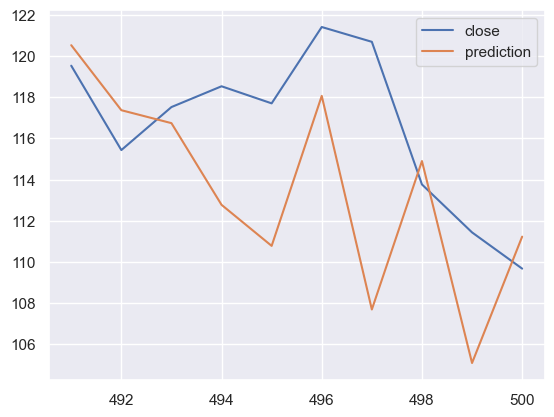

In [33]:
pd.concat([y_true, y_pred], axis=1).plot()

In [34]:
mean_absolute_percentage_error(y_true, y_pred)

0.035562702865338205

In [35]:
mean_squared_error(y_true, y_pred)

31.079985035563972